In [1]:
from torchvision.datasets import FashionMNIST
import torchvision.models as models
import torchvision.transforms as tfm 
from torch.utils.data import DataLoader

import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn as nn

from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

sns.set_style('dark')

In [2]:
# All hyperparameters are set to values as mentioned in Section C of the paper.

seed = 42
DEBUG = False     # Trains only on 3 batches 
BS = 128         # Batch Size
LR = 1e-1        # Learning Rate 
WD = 1e-4         # Weight Decay. In the paper (pg. 13, para 1) they have mentioned wd 1e4, but in their script they have used 1e-4. 1e4 leads to exploding gradients.
                              
MOMENTUM=0.9     
EPOCHS = 200

MSDA = 'mixup'     # Choose one amongst mixup,fmix,cutmix and None
ALPHA = 1        # Parameter for Beta Distribution
DELTA = 3        # Decay Power for Fmix
SHAPE = (28,28)       # Shape of masks. Should be same as shape of image

DIR = '/kaggle/working/'    # Location to save log file and trained weights.
num_classes = 10                             # Number of classes in the dataset

RESUME = False

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [4]:
train_tfm = tfm.Compose([tfm.RandomCrop(28, padding=4), 
                         tfm.RandomHorizontalFlip(),
                         tfm.ToTensor(),
                         tfm.Normalize(mean=(0.1307,), std=(0.3081,))
                         ])
test_tfm = tfm.Compose([ tfm.ToTensor(),
                         tfm.Normalize(mean=(0.1307,), std=(0.3081,))
                         ])


fmnist_train = FashionMNIST('./', train=True, transform=train_tfm, download=True)
fmnist_test = FashionMNIST('./', train=False, transform=test_tfm, download=True)

print('Train data shape: ', fmnist_train.data.size())
print('Train labels shape: ', fmnist_train.targets.size())
print('Test data shape: ', fmnist_test.data.size())
print('Test labels shape: ', fmnist_test.targets.size())


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!
Train data shape:  torch.Size([60000, 28, 28])
Train labels shape:  torch.Size([60000])
Test data shape:  torch.Size([10000, 28, 28])
Test labels shape:  torch.Size([10000])


/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [5]:
ll = """0 T-shirt/top
 1 Trouser
 2 Pullover
 3 Dress
 4 Coat
 5 Sandal
 6 Shirt
 7 Sneaker
 8 Bag
 9 Ankleboot."""

labels={}
for i,j in zip(ll.split(' ')[::2], ll.split(' ')[1::2]):
  labels[int(i)]=j[:-1]

print(labels)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankleboot'}


In [6]:
def mixup(imgs, labels, alpha):
  lam = np.random.beta(alpha,alpha)
  index = torch.randperm(len(imgs))
  shuffled_imgs = imgs[index]
  shuffled_labels = labels[index]
  new_imgs = lam*imgs + (1-lam)*shuffled_imgs

  return new_imgs, shuffled_labels, lam 

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    return new_data, shuffled_target, lam

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(epoch, dataloader, model, criterion, optimizer, scheduler, msda):
  train_loss = 0
  predictions = []
  truth = []
  length = len(dataloader)
  model.train()
  optimizer.zero_grad()
  iterator = tqdm(enumerate(dataloader), total=length, leave=False, desc=f'Epoch {epoch+1}/{EPOCHS}')

  for i, (img, label) in iterator:

    # This block implements fmix. 

    if msda=='fmix':
      # 'lam' is sampled from beta distribution with parameter alpha. 
      img, index, lam = sample_and_apply(img, alpha=ALPHA, decay_power=DELTA, shape=SHAPE)
      # 'img' is the batch with fmixed images
      img = img.type(torch.FloatTensor)    
      shuffled_label = label[index].to(device)
    elif msda=='mixup':
      img, shuffled_label, lam = mixup(img, label, alpha=ALPHA)
      shuffled_label = shuffled_label.to(device)
    elif msda=='cutmix':
      img, shuffled_label, lam = cutmix(img, label, alpha=ALPHA)
      shuffled_label = shuffled_label.to(device)    

    img = img.to(device)
    label = label.to(device)
    output = model(img)
  
    # Criterion changed to take into account the mixing of labels
    if msda in ['fmix','mixup','cutmix']:
      loss = lam*criterion(output, label) + (1-lam)*criterion(output, shuffled_label)
    elif msda is None: 
      loss = criterion(output, label)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_loss += loss.item()/length
 
    prob = torch.softmax(output.detach().cpu(),1).numpy()
    pred = np.argmax(prob, 1)

    predictions.append(pred)
    truth.append(label.detach().cpu().numpy())

    if DEBUG:
      if i==3:
        break

    if scheduler:
      scheduler.step()

  predictions = np.concatenate(predictions)
  truth = np.concatenate(truth)

  acc = accuracy_score(truth, predictions)

  return train_loss, acc

def test(epoch, dataloader, model, criterion):
  test_loss = 0
  predictions = []
  truth = []
  length = len(dataloader)
  model.eval()
  iterator = tqdm(enumerate(dataloader), total=length, leave=False, desc=f'Epoch {epoch+1}/{EPOCHS}')

  for i, (img, label) in iterator:
    img = img.to(device)
    label = label.to(device)
    output = model(img)

    loss = criterion(output,label)
    test_loss += loss.item()/length

    
    prob = torch.softmax(output.detach().cpu(), 1).numpy()
    pred = np.argmax(prob, 1)

    predictions.append(pred)   
    truth.append(label.detach().cpu().numpy())

    if DEBUG:
      if i==3:
        break

  predictions = np.concatenate(predictions)
  truth = np.concatenate(truth)

  acc = accuracy_score(truth, predictions)

  return test_loss, acc

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out)
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out)
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, nc=3):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(nc, 64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, lin=0, lout=5):
        out = x
        if lin < 1 and lout > -1:
            out = self.conv1(out)
            out = self.bn1(out)
            out = F.relu(out)
        if lin < 2 and lout > 0:
            out = self.layer1(out)
        if lin < 3 and lout > 1:
            out = self.layer2(out)
        if lin < 4 and lout > 2:
            out = self.layer3(out)
        if lin < 5 and lout > 3:
            out = self.layer4(out)
        if lout > 4:
            # out = F.avg_pool2d(out, 4)
            out = F.adaptive_avg_pool2d(out, (1, 1))

            out = out.view(out.size(0), -1)
            out = self.linear(out)
        return out


def ResNet18(num_classes=10, nc=3):
    return ResNet(PreActBlock, [2, 2, 2, 2], num_classes=num_classes, nc=nc)


def ResNet34(num_classes=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)


def ResNet50(num_classes=10):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)


def ResNet101(num_classes=10):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes)


def ResNet152(num_classes=10):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes=num_classes)


def test_model():
    net = ResNet18()
    y = net(Variable(torch.randn(1, 3, 32, 32)))
    print(y.size())


def resnet():
    return ResNet18()

In [9]:
model = ResNet18(nc=1)
optimizer = optim.SGD(model.parameters(), lr=LR, weight_decay=WD, momentum=MOMENTUM)
criterion = nn.CrossEntropyLoss()

# Multiplies the LR with 0.1 at epoch 100 and 150 as mentioned in the paper
lmd = lambda x: 0.1 if x in [100,150] else 1
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmd)

trainloader = DataLoader(fmnist_train, batch_size=BS, shuffle=True)
testloader = DataLoader(fmnist_test, batch_size=BS, shuffle=False)

if RESUME:
  recorder = torch.load(DIR+f'fmnist_{MSDA}_preact_resnet18_recorder_2.pth')
  model.load_state_dict(recorder['model'])
  optimizer.load_state_dict(recorder['optimizer'])
  scheduler.load_state_dict(recorder['scheduler'])
  resume_epoch = recorder['epoch']

def get_lr(optimizer):
  lr_list = []
  for p in optimizer.param_groups:
    lr_list.append(p['lr'])

  return lr_list[0]

In [10]:
history = {'train_loss': [],
           'test_loss': [],
           'train_acc': [],
           'test_acc': []
           }           

best_loss = np.inf
best_acc = 0

model.to(device)

for epoch in range(EPOCHS):
  
  if RESUME:
    epoch = resume_epoch + 1

  t_loss, t_acc = train(epoch, trainloader, model, criterion, optimizer, scheduler=None, msda=MSDA)
  lr = get_lr(optimizer)
  print('Epoch {}/{} (train) || Loss: {:.4f} Acc: {:.4f} LR: {:.5f}'.format(epoch+1, EPOCHS, t_loss, t_acc, lr))

  test_loss, test_acc = test(epoch, testloader, model, criterion)
  print('Epoch {}/{} (test) || Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, EPOCHS, test_loss, test_acc))

  history['train_loss'].append(t_loss)
  history['test_loss'].append(test_loss)
  history['train_acc'].append(t_acc)
  history['test_acc'].append(test_acc)

  scheduler.step()  

  content = 'Train Loss: {:.4f} Test Loss: {:.4f}\
  Train Acc: {:.4f} Test Acc: {:.4f}'.format(t_loss, test_loss, t_acc, test_acc)

  recorder={}

  recorder['epoch'] = epoch
  recorder['model'] = model.state_dict()
  recorder['optimizer'] = optimizer.state_dict()
  recorder['scheduler'] = scheduler.state_dict()

  torch.save(recorder, DIR+f'fmnist_{MSDA}_preact_resnet18_recorder_2.pth')

  with open(DIR+f'fmnist_{MSDA}_preact_resnet18_log_2.txt', 'a') as logger:
    logger.write(content + '\n')

  if test_loss<best_loss:
    torch.save(model.state_dict(), DIR+f'fmnist_{MSDA}_preact_resnet18_loss_2.pth')
    best_loss = test_loss

  if test_acc>best_acc:
    torch.save(model.state_dict(), DIR+f'fmnist_{MSDA}_preact_resnet18_acc_2.pth') 
    best_acc = test_acc
    

Epoch 1/200 (train) || Loss: 1.3325 Acc: 0.3940 LR: 0.10000


Epoch 1/200 (test) || Loss: 0.6101 Acc: 0.7853


Epoch 2/200 (train) || Loss: 1.0186 Acc: 0.4950 LR: 0.10000


Epoch 2/200 (test) || Loss: 0.4613 Acc: 0.8575


Epoch 3/200 (train) || Loss: 0.9608 Acc: 0.5105 LR: 0.10000


Epoch 3/200 (test) || Loss: 0.3821 Acc: 0.8876


Epoch 4/200 (train) || Loss: 0.8932 Acc: 0.5110 LR: 0.10000


Epoch 4/200 (test) || Loss: 0.4132 Acc: 0.8809


Epoch 5/200 (train) || Loss: 0.8607 Acc: 0.5020 LR: 0.10000


Epoch 5/200 (test) || Loss: 0.3318 Acc: 0.9056


Epoch 6/200 (train) || Loss: 0.8289 Acc: 0.5143 LR: 0.10000


Epoch 6/200 (test) || Loss: 0.3220 Acc: 0.8967


Epoch 7/200 (train) || Loss: 0.8331 Acc: 0.5113 LR: 0.10000


Epoch 7/200 (test) || Loss: 0.2873 Acc: 0.9143


Epoch 8/200 (train) || Loss: 0.8060 Acc: 0.5198 LR: 0.10000


Epoch 8/200 (test) || Loss: 0.3057 Acc: 0.9021


Epoch 9/200 (train) || Loss: 0.7759 Acc: 0.5122 LR: 0.10000


Epoch 9/200 (test) || Loss: 0.2939 Acc: 0.9145


Epoch 10/200 (train) || Loss: 0.7723 Acc: 0.4973 LR: 0.10000


Epoch 43/200 (train) || Loss: 0.7017 Acc: 0.5363 LR: 0.10000


Epoch 43/200 (test) || Loss: 0.2587 Acc: 0.9259


Epoch 52/200 (test) || Loss: 0.2162 Acc: 0.9441


Epoch 71/200 (train) || Loss: 0.6694 Acc: 0.5394 LR: 0.10000


Epoch 80/200 (train) || Loss: 0.6790 Acc: 0.5689 LR: 0.10000


Epoch 80/200 (test) || Loss: 0.2209 Acc: 0.9412


Epoch 99/200 (train) || Loss: 0.6529 Acc: 0.5206 LR: 0.10000


Epoch 99/200 (test) || Loss: 0.2404 Acc: 0.9366


Epoch 100/200 (train) || Loss: 0.6670 Acc: 0.5102 LR: 0.10000


Epoch 100/200 (test) || Loss: 0.3215 Acc: 0.9415


Epoch 134/200 (test) || Loss: 0.1654 Acc: 0.9574


Epoch 143/200 (train) || Loss: 0.5685 Acc: 0.5354 LR: 0.01000


Epoch 143/200 (test) || Loss: 0.1828 Acc: 0.9563


Epoch 152/200 (train) || Loss: 0.5676 Acc: 0.5341 LR: 0.00100


Epoch 152/200 (test) || Loss: 0.1641 Acc: 0.9585


Epoch 161/200 (train) || Loss: 0.5407 Acc: 0.5257 LR: 0.00100


Epoch 161/200 (test) || Loss: 0.2045 Acc: 0.9554


Epoch 170/200 (train) || Loss: 0.5415 Acc: 0.5670 LR: 0.00100


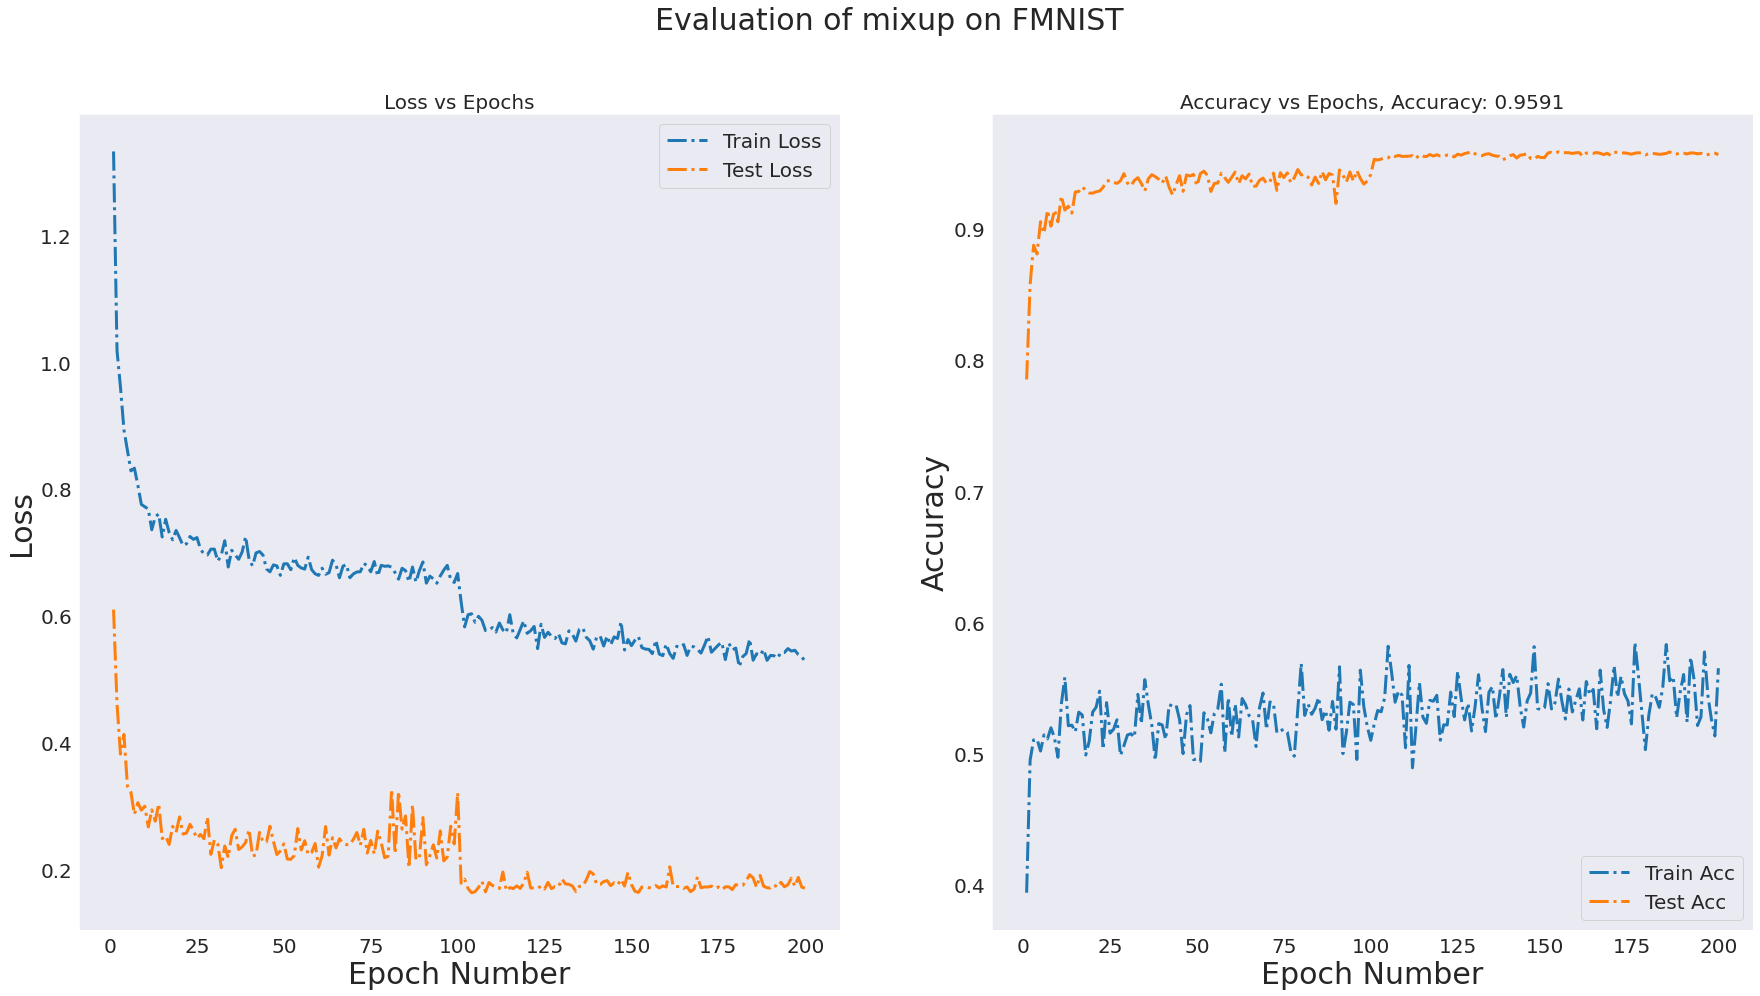

In [11]:
plt.figure(figsize=(30,15))
plt.suptitle(f'Evaluation of {MSDA} on FMNIST', fontsize=30)

plt.subplot(1,2,1)
x_label = np.arange(1, EPOCHS+1, dtype='int')
plt.plot(x_label, history['train_loss'], linestyle='-.',linewidth=3, label='Train Loss')
plt.plot(x_label, history['test_loss'], linestyle='-.', linewidth=3, label='Test Loss')
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Epoch Number', fontsize=30)
plt.ylabel('Loss', fontsize=30)
plt.title('Loss vs Epochs', fontsize=20)

plt.subplot(1,2,2)
plt.plot(x_label, history['train_acc'], linestyle='-.', linewidth=3, label='Train Acc')
plt.plot(x_label, history['test_acc'], linestyle='-.', linewidth=3, label='Test Acc')
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Epoch Number', fontsize=30)
plt.ylabel('Accuracy', fontsize=30)
plt.title('Accuracy vs Epochs, Accuracy: {:.4f}'.format(max(history['test_acc'])), fontsize=20)

# plt.tight_layout()

plt.savefig(DIR+f'fmnist_{MSDA}_preact_resnet18_2.png')